# DBSCAN
-------

In [1]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.manifold import TSNE

In [3]:
df = pd.read_csv('wholesale_customers_data.csv')
print(df.shape)
print(df.columns)
df.head()

(440, 8)
Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# Without Preprocessing

In [4]:
# df_ = df.drop(['Channel', 'Region'], axis=1)
# scaler = StandardScaler()
# scaled_X = scaler.fit_transform(df_)

# neigh = NearestNeighbors(n_neighbors=11)
# neigh.fit(scaled_X)
# distances, indices = neigh.kneighbors(scaled_X)

# plt.plot(np.sort(distances[:,10]))
# plt.xlabel("Points")
# plt.ylabel("Distance")

# min_sample = np.log(scaled_X.shape[0])

# eps=0.75
# min_sample=6

# dbscan = DBSCAN(eps=eps,min_samples=min_sample)
# dbscan.fit(scaled_X)

# df_['Labels'] = dbscan.labels_

# df_.Labels.value_counts().to_frame()

# With Preprocessing

In [5]:
# one-hot encoding
print(df['Channel'].unique())
print(df['Region'].unique())

[2 1]
[3 1 2]


In [6]:
n_row = df.shape[0]
one_hot_encoding_columns = ['Channel1','Channel2','Region1','Region2','Region3']
for col in one_hot_encoding_columns:
  df[col] = [0] * n_row

for i in range(n_row):
  df['Channel{}'.format(str(df['Channel'][i]))][i] = 1
  df['Region{}'.format(str(df['Region'][i]))][i] = 1

df = df.drop(['Channel','Region'], axis=1)

df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel1,Channel2,Region1,Region2,Region3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1


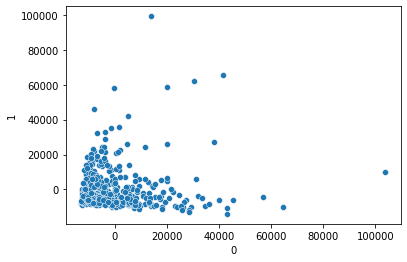

In [7]:
# plot
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(df), columns=[0, 1])
sns.scatterplot(pca_df[0], pca_df[1], legend="full")
plt.show()

      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  1.207859  1.199958  1.192603  1.047915          1.158490    1.132722
1  1.190486  1.200426  1.199687  1.143297          1.165728    1.143594
2  1.187224  1.197221  1.193096  1.154718          1.167962    1.193723
3  1.209171  1.128277  1.174081  1.187474          1.091355    1.143847
4  1.223862  1.182146  1.191096  1.171580          1.143615    1.180785


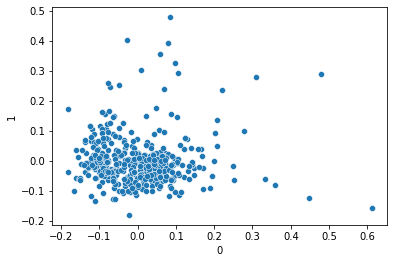

In [8]:
# log1p
# 데이터의 밀도를 좀 더 고르게 만드는 작업

# 반복해서 하게되면..?
log_df = np.log1p(np.log1p(np.log1p(df.iloc[:,0:6])))
print(log_df.head())


# plot
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(log_df), columns=[0, 1])
sns.scatterplot(pca_df[0], pca_df[1], legend="full")
plt.show()

      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  0.913516  0.817490  0.895600  0.431189          0.868573    0.821241
1  0.886250  0.819091  0.906792  0.701217          0.880376    0.838854
2  0.881130  0.808125  0.896378  0.733550          0.884017    0.920067
3  0.915574  0.572194  0.866333  0.826283          0.759106    0.839264
4  0.938631  0.756537  0.893217  0.781288          0.844320    0.899106


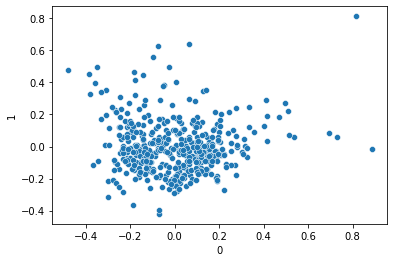

In [9]:
# normalize
normalizer = MinMaxScaler()
normalized_df = pd.DataFrame(
    data = normalizer.fit_transform(log_df),
    columns = log_df.columns
    )

print(normalized_df.head())

# plot
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(normalized_df), columns=[0, 1])
sns.scatterplot(pca_df[0], pca_df[1], legend="full")
plt.show()

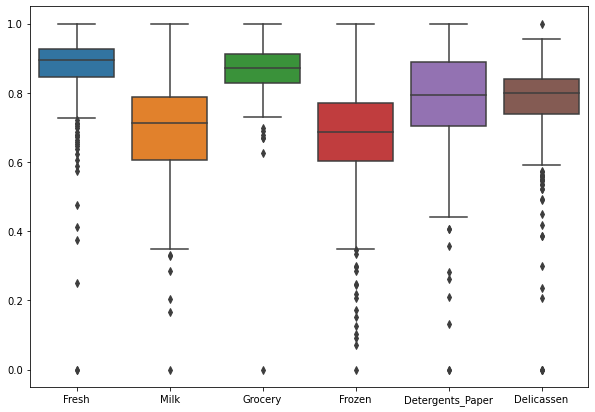

In [10]:
plt.figure(figsize=(10,7))
sns.boxplot(data=normalized_df)
plt.show()

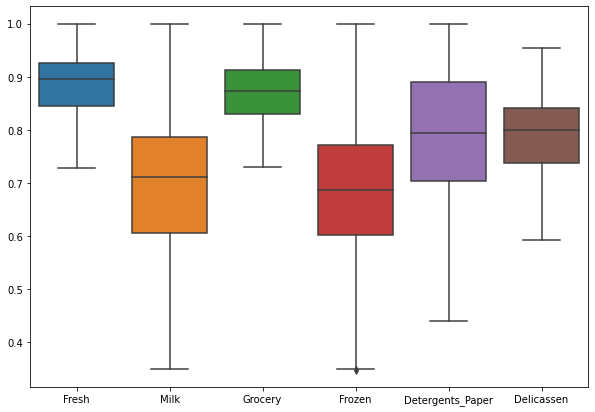

In [11]:
# remove outlier, IQR
normalized_iqr_df = normalized_df.copy()

for col in normalized_iqr_df.columns:
  q25 = normalized_iqr_df[col].quantile(0.25)
  q50 = normalized_iqr_df[col].quantile(0.5)
  q75 = normalized_iqr_df[col].quantile(0.75)
  iqr=q75-q25

  normalized_iqr_df.loc[normalized_iqr_df[col] > q75 + 1.5 * iqr, col] = q75
  normalized_iqr_df.loc[normalized_iqr_df[col] < q25 - 1.5 * iqr, col] = q25

plt.figure(figsize=(10,7))
sns.boxplot(data=normalized_iqr_df)
plt.show()

In [12]:
normalized_iqr_df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.885142,0.697814,0.869947,0.681477,0.789034,0.791496
std,0.053875,0.120571,0.051893,0.124782,0.112927,0.065289
min,0.728328,0.349989,0.730187,0.348319,0.439932,0.591848
25%,0.844723,0.605550,0.829454,0.602725,0.704310,0.737737
50%,0.895165,0.711596,0.872510,0.685738,0.793626,0.799928
75%,0.926311,0.787049,0.911799,0.772082,0.890014,0.840317
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.955076


min_sample:  7
(440, 8)


Text(0, 0.5, 'Distance')

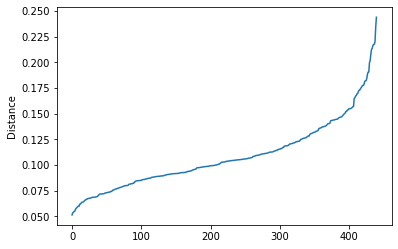

In [13]:
# Using algorithm to find epsilon

min_sample = int(np.ceil(np.log(normalized_iqr_df .shape[0])))
print('min_sample: ',min_sample)

neigh = NearestNeighbors(n_neighbors=min_sample + 1)
neigh.fit(normalized_iqr_df)
distances, indices = neigh.kneighbors(normalized_iqr_df)

print(distances.shape)

plt.plot(np.sort(distances[:,min_sample]))
plt.ylabel("Distance")

In [14]:
def iterable_DBscan(data, min_eps, max_eps, eps_gap, min_sample):
  i = min_eps

  while i <= max_eps:
    db = DBSCAN(eps=i, min_samples=min_sample)
    cluster = db.fit(data)
    cluster_id = pd.DataFrame({"cluster":cluster.labels_})

    # for plot
    p = PCA(n_components=2)
    df_p = pd.DataFrame(p.fit_transform(data), columns=[0, 1])
    sns.scatterplot(df_p[0], df_p[1], hue = cluster.labels_, legend="full")
    plt.title('DBScan with eps {}'.format(i))
    plt.show()

    # evaluate
    try:
      print('Silhouette Coefficient: {:.4f}'.format(silhouette_score(data, cluster_id)))
      print('Davies Bouldin Index: {:.4f}'.format(davies_bouldin_score(data, cluster_id)))  
    except Exception as e:
      print('평가지표 계산 중 에러가 발생했습니다.\n', e)
    print('---------------------\n\n\n')

    i += eps_gap


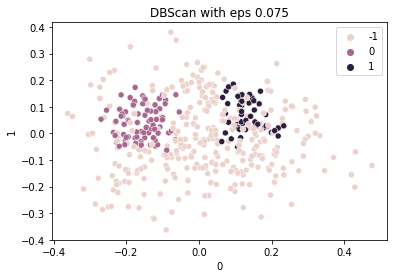

Silhouette Coefficient: -0.0474
Davies Bouldin Index: 2.0513
---------------------





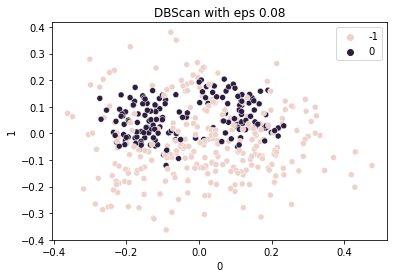

Silhouette Coefficient: 0.0378
Davies Bouldin Index: 3.8638
---------------------





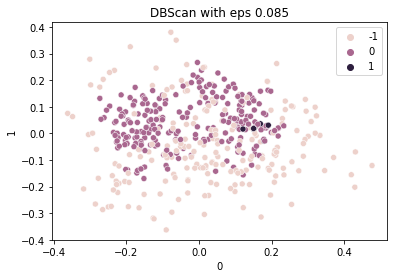

Silhouette Coefficient: -0.0541
Davies Bouldin Index: 3.2087
---------------------





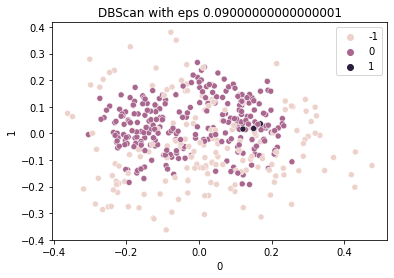

Silhouette Coefficient: -0.0572
Davies Bouldin Index: 3.5877
---------------------





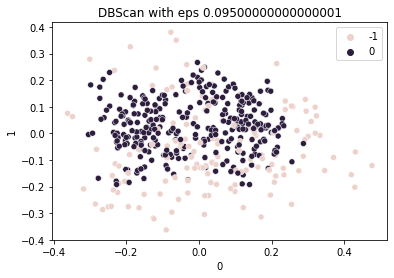

Silhouette Coefficient: 0.1345
Davies Bouldin Index: 4.2445
---------------------





In [15]:
min_eps = 0.075
max_eps = 0.1
eps_gap = 0.005

iterable_DBscan(normalized_iqr_df, min_eps, max_eps, eps_gap, min_sample)


> 값이...

# PCA

In [16]:
## PCA
pca = PCA(n_components=int(normalized_iqr_df.shape[1] / 2))
reduced_df = pca.fit_transform(normalized_iqr_df)
reduced_df.shape

(440, 3)

min_sample:  7
(440, 8)


Text(0, 0.5, 'Distance')

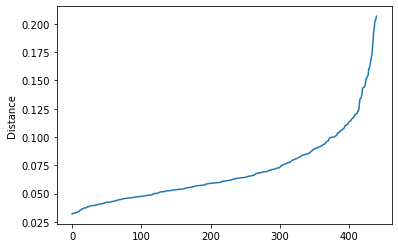

In [17]:
min_sample = int(np.ceil(np.log(reduced_df .shape[0])))
print('min_sample: ',min_sample)

neigh = NearestNeighbors(n_neighbors=min_sample + 1)
neigh.fit(reduced_df)
distances, indices = neigh.kneighbors(reduced_df)

print(distances.shape)

plt.plot(np.sort(distances[:,min_sample]))
plt.ylabel("Distance")

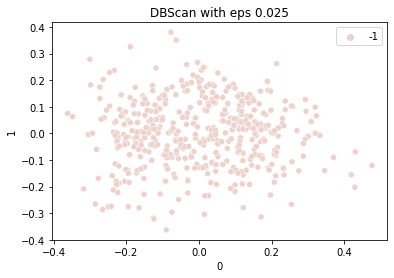

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





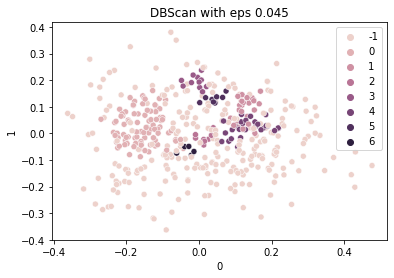

Silhouette Coefficient: -0.1731
Davies Bouldin Index: 2.7267
---------------------





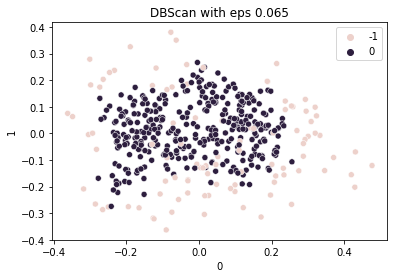

Silhouette Coefficient: 0.2128
Davies Bouldin Index: 4.9819
---------------------





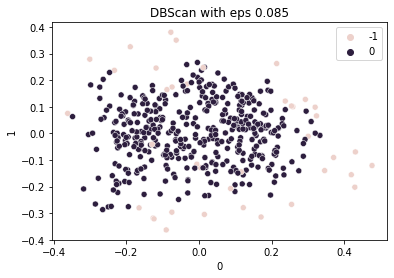

Silhouette Coefficient: 0.2902
Davies Bouldin Index: 5.0555
---------------------





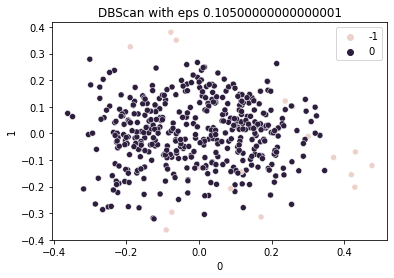

Silhouette Coefficient: 0.3412
Davies Bouldin Index: 2.8942
---------------------





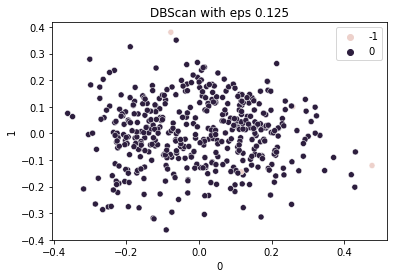

Silhouette Coefficient: 0.3404
Davies Bouldin Index: 2.5992
---------------------





In [18]:
min_eps = 0.025
max_eps = 0.125
eps_gap = 0.02

iterable_DBscan(reduced_df, min_eps, max_eps, eps_gap, min_sample)

> plot만 봐도 그렇지만 평가지표를 보면 제대로 클러스터링이 되고 있지 않다.
값이 너무 낮고 높다.

# Region, Channel 별로 분리

In [19]:
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel1,Channel2,Region1,Region2,Region3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1


------------------------Channel1------------------------


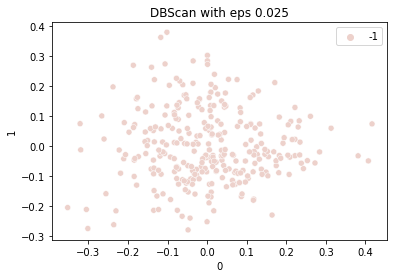

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





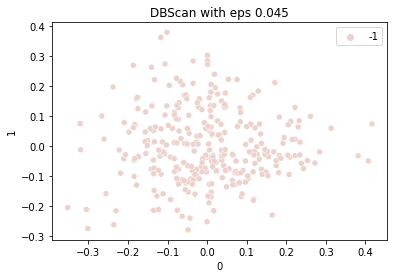

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





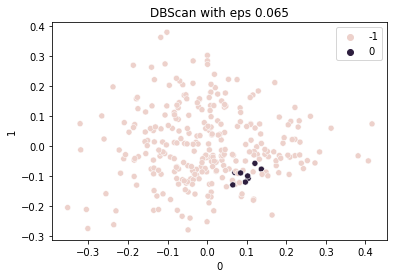

Silhouette Coefficient: -0.1325
Davies Bouldin Index: 1.6965
---------------------





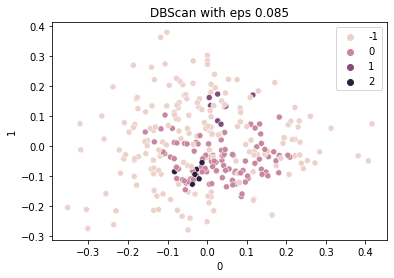

Silhouette Coefficient: -0.1513
Davies Bouldin Index: 2.8378
---------------------





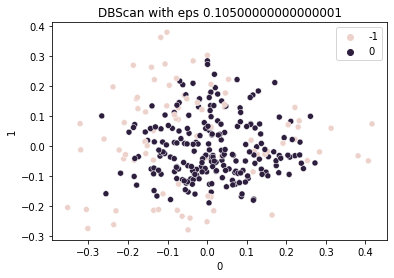

Silhouette Coefficient: 0.1716
Davies Bouldin Index: 5.7966
---------------------





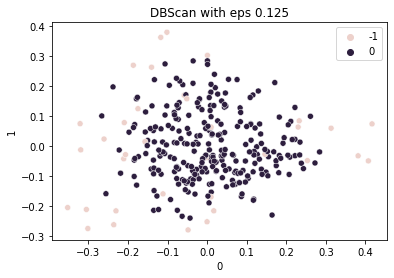

Silhouette Coefficient: 0.2768
Davies Bouldin Index: 6.2964
---------------------



------------------------Channel2------------------------


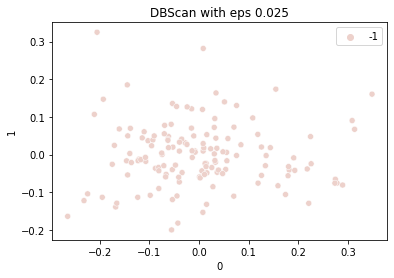

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





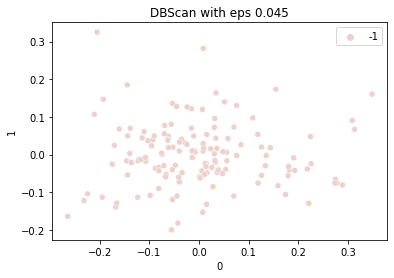

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





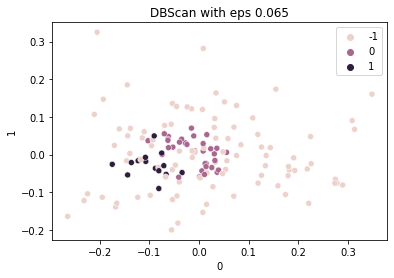

Silhouette Coefficient: -0.0831
Davies Bouldin Index: 4.2588
---------------------





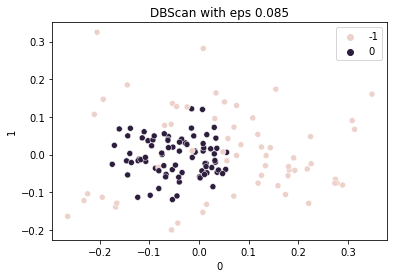

Silhouette Coefficient: 0.1954
Davies Bouldin Index: 2.8560
---------------------





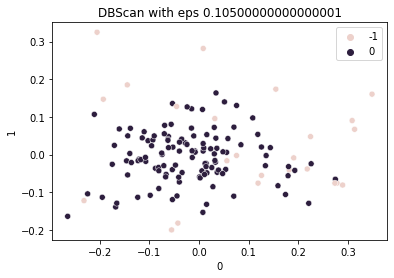

Silhouette Coefficient: 0.2802
Davies Bouldin Index: 2.9603
---------------------





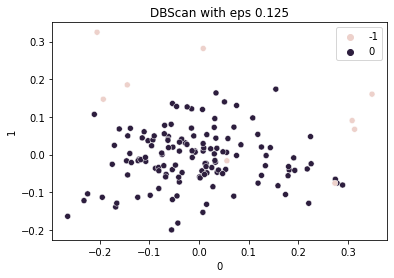

Silhouette Coefficient: 0.3609
Davies Bouldin Index: 2.4266
---------------------



------------------------Region1------------------------


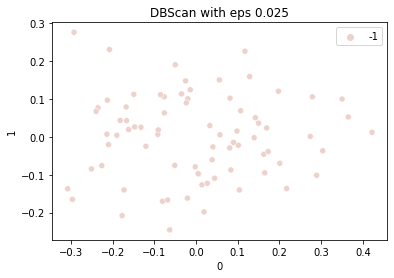

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





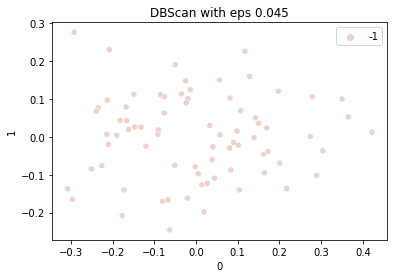

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





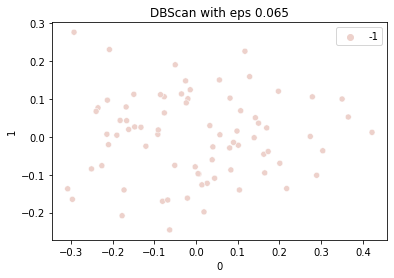

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





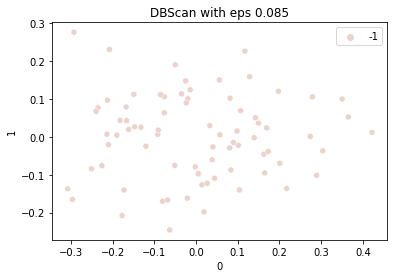

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





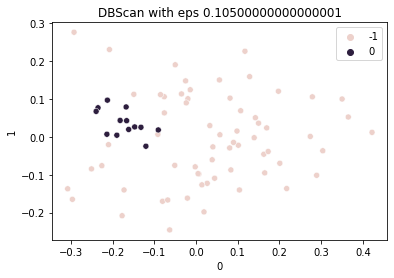

Silhouette Coefficient: 0.0966
Davies Bouldin Index: 1.3527
---------------------





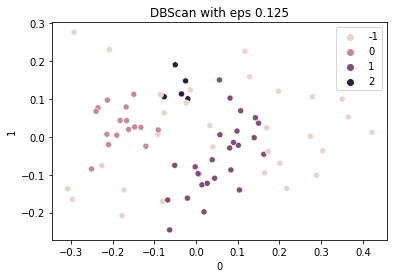

Silhouette Coefficient: 0.0761
Davies Bouldin Index: 3.3729
---------------------



------------------------Region2------------------------


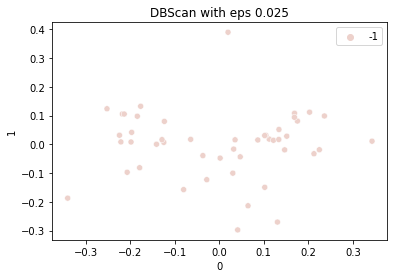

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





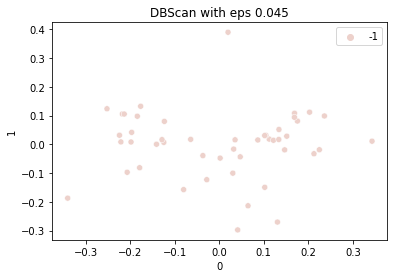

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





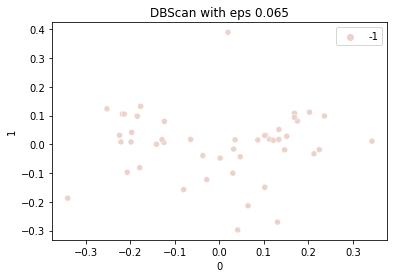

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





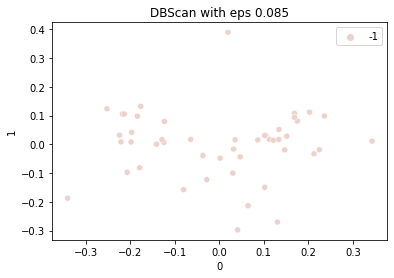

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





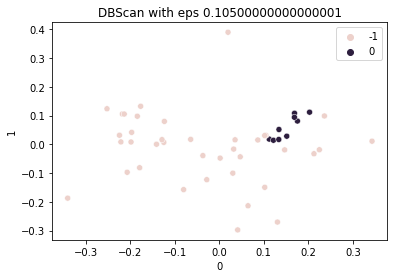

Silhouette Coefficient: 0.0930
Davies Bouldin Index: 1.4193
---------------------





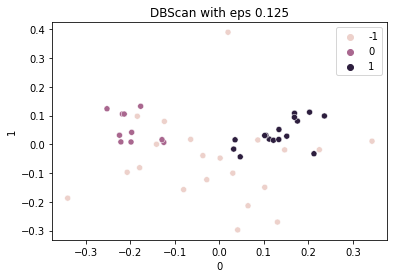

Silhouette Coefficient: 0.1820
Davies Bouldin Index: 1.6933
---------------------



------------------------Region3------------------------


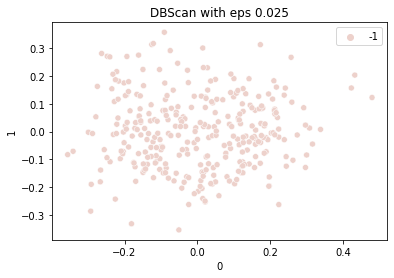

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





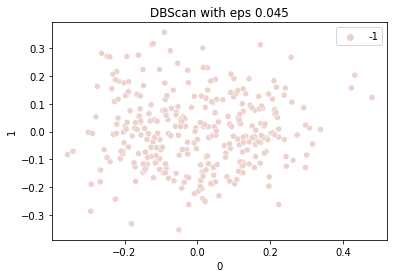

평가지표 계산 중 에러가 발생했습니다.
 Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
---------------------





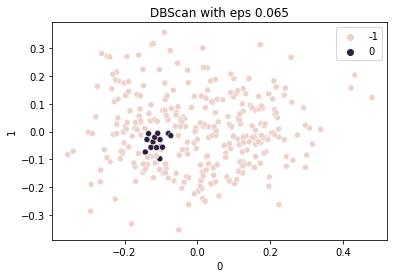

Silhouette Coefficient: -0.1438
Davies Bouldin Index: 2.0339
---------------------





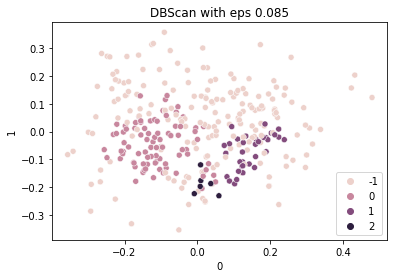

Silhouette Coefficient: -0.0653
Davies Bouldin Index: 1.8970
---------------------





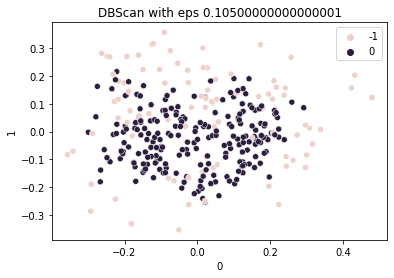

Silhouette Coefficient: 0.1488
Davies Bouldin Index: 5.0834
---------------------





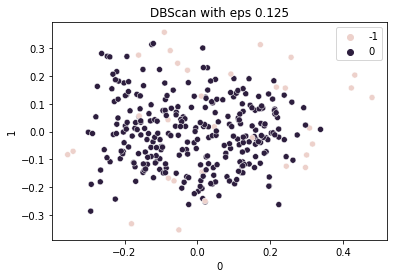

Silhouette Coefficient: 0.2296
Davies Bouldin Index: 4.6802
---------------------





In [23]:
category_col = ['Channel1',	'Channel2',	'Region1',	'Region2',	'Region3']
normalized_iqr_df
for col in category_col:
  print('------------------------{}------------------------'.format(col))
  row_idx = df.index[df[col]==1].tolist()
  iterable_DBscan(normalized_iqr_df.loc[row_idx], min_eps, max_eps, eps_gap, min_sample)
  